In [11]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import scanpy as sc
import pandas as pd
import scanpy as sc 
import sys 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
warnings.filterwarnings('ignore')
sys.path.append('../../src')
from spaceoracle.plotting.cartography import xy_from_adata
from spaceoracle.virtual_tissue import VirtualTissue

In [13]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq.h5ad')
adata

AnnData object with n_obs × n_vars = 23409 × 3311
    obs: 'cell_type', 'cell_type_int', 'seurat_clusters', 'umap_1', 'umap_2', 'author_cell_type'
    uns: 'cell_thresholds', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_umap', 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [14]:
savefig_params = {
    'dpi': 300, 
    'bbox_inches': 'tight', 
    'format': 'svg', 
    'transparent': True
}

plt.rcParams.update({
    "text.usetex": False,
    "svg.fonttype": 'none'
})

In [15]:
df = pd.read_parquet('/Users/koush/Downloads/old_Tbx6_4n_0x.parquet')

In [4]:
# from spaceoracle.oracles import BaseTravLR

# BaseTravLR.impute_clusterwise(adata)

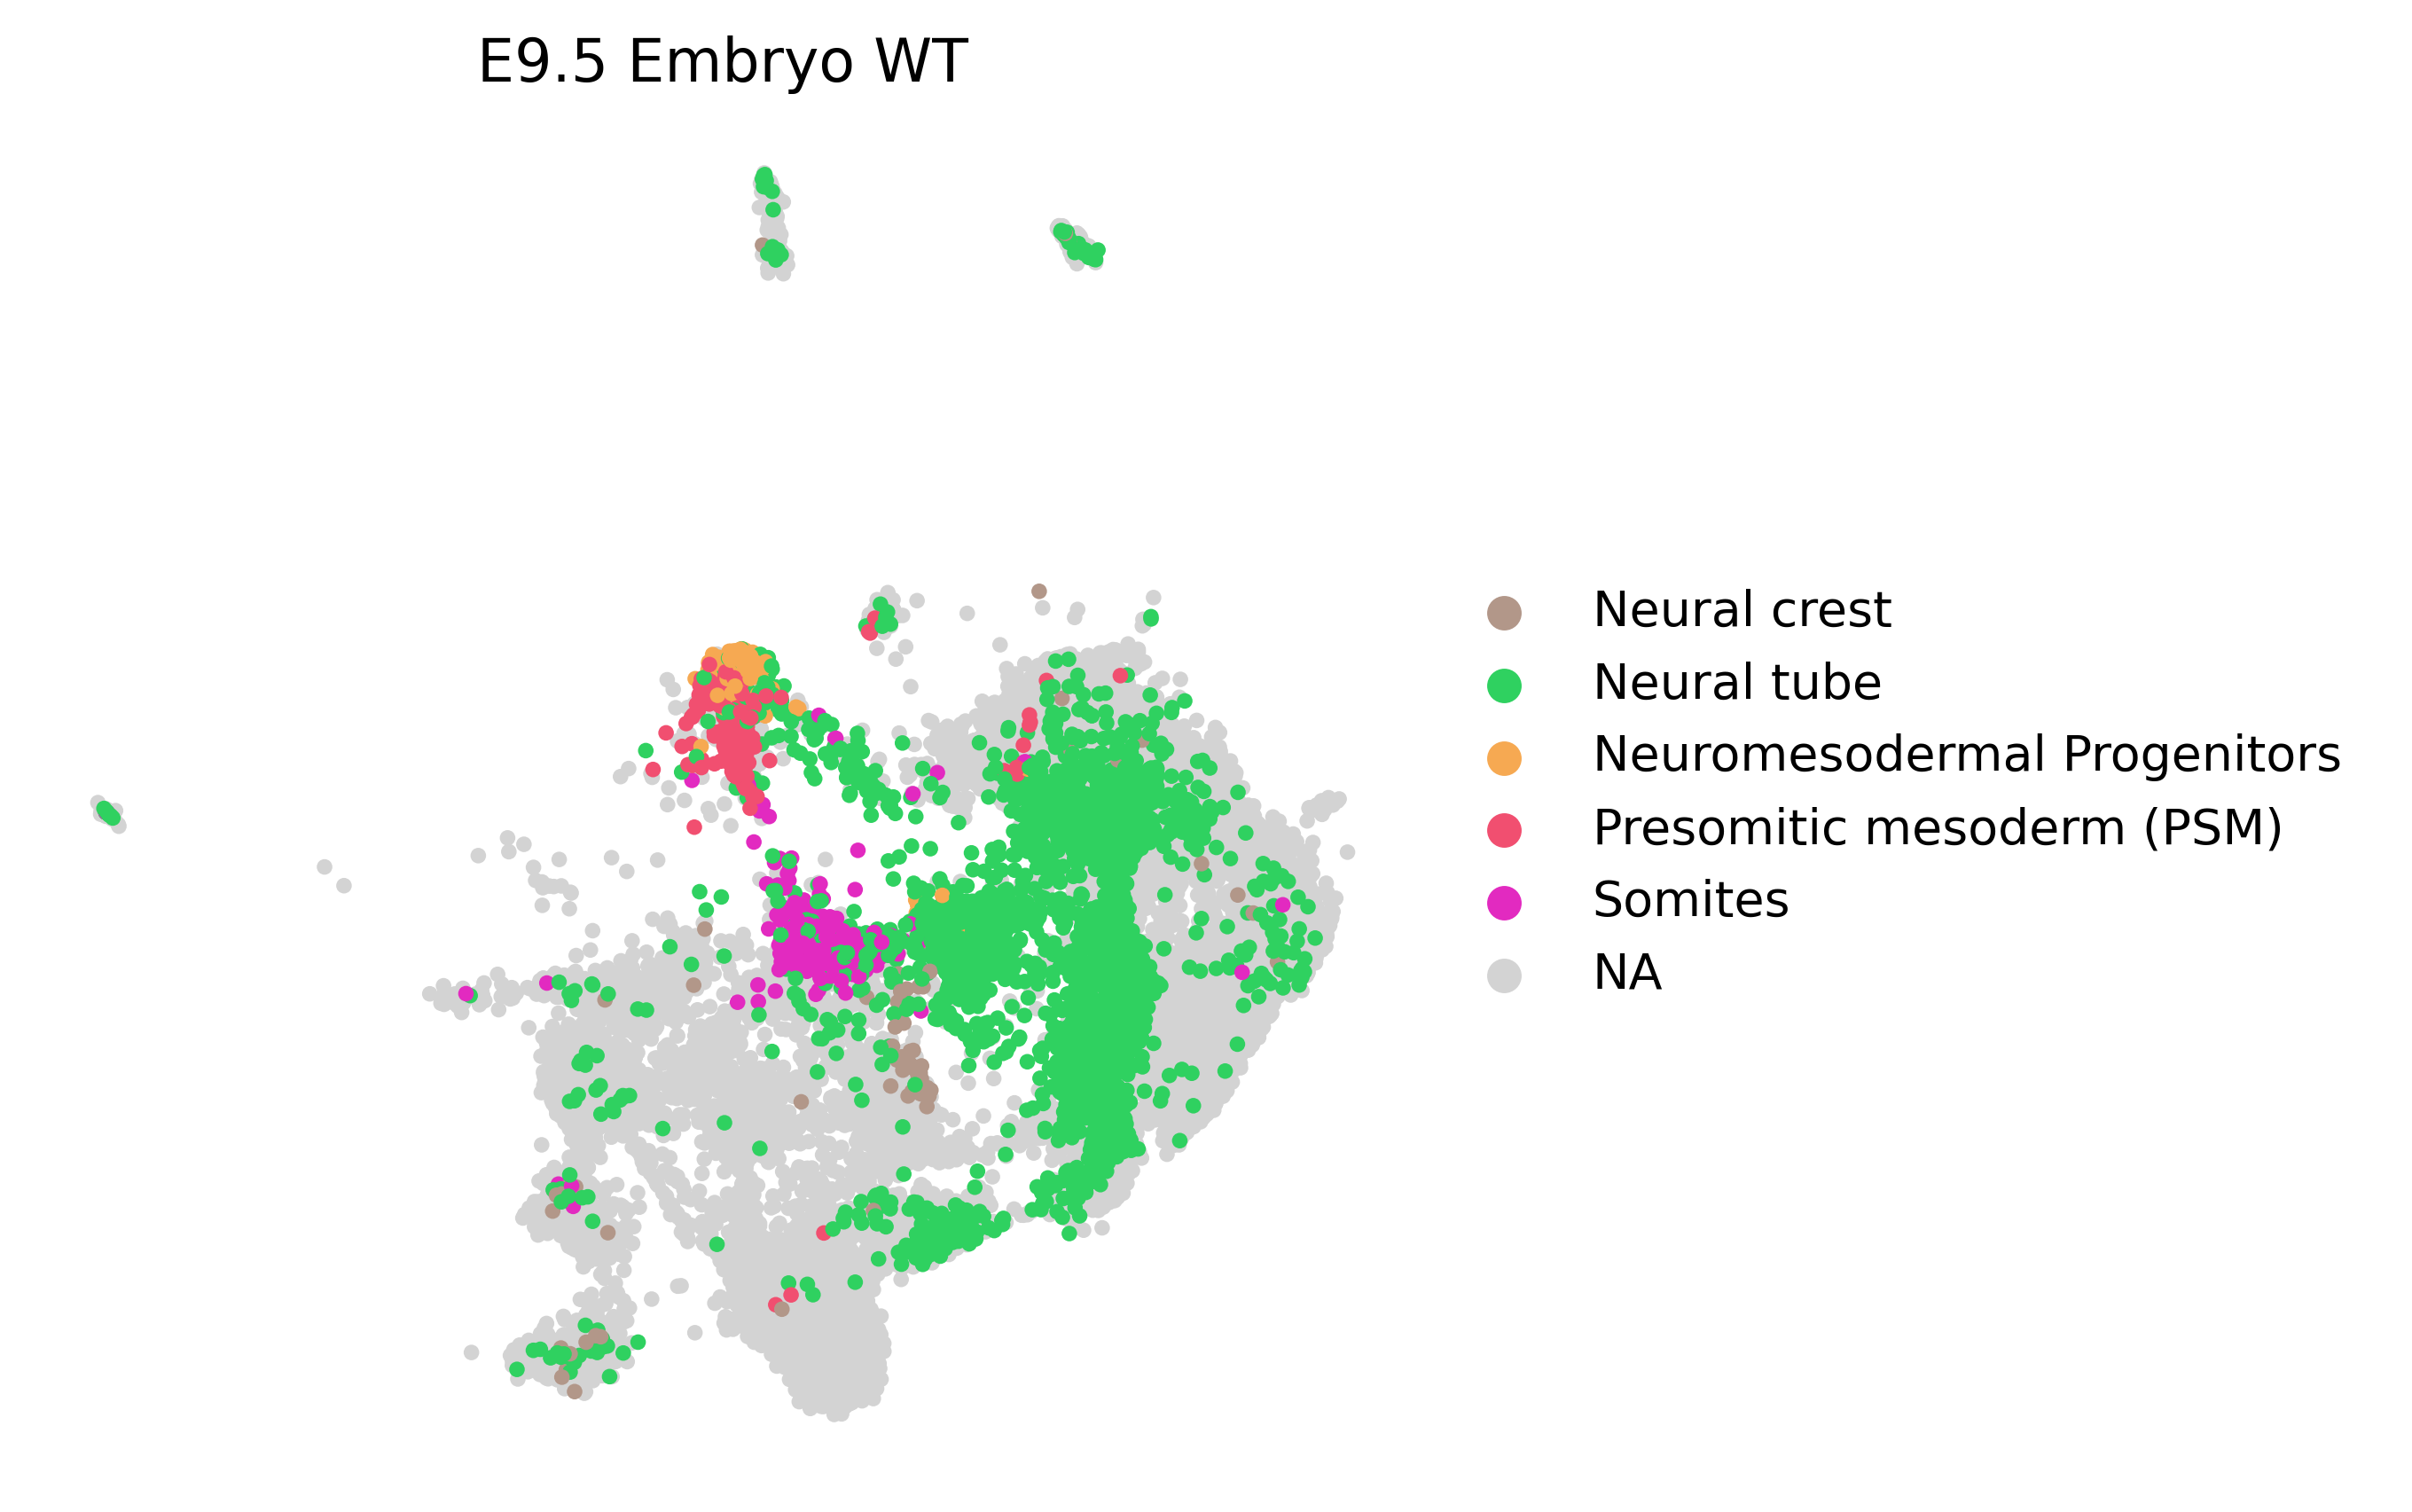

In [16]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 200

sc.pl.embedding(adata, 
        color=['cell_type'], frameon=False, basis='umap', s=40, 
        groups=['Somites', 'Presomitic mesoderm (PSM)', 'Neural crest', 'Neural tube', 'Neuromesodermal Progenitors '], 
        add_outline=False,
        title=['E9.5 Embryo WT'],
                palette = {
                    'Ectopic tube': "#1af8e6",
                    'Neural tube': "#2fd160",
                    'Neural plate': "#e3f637",
                    'Neural crest': "#b29789",
                    'Somites': "#e22ac0",
                    'Presomitic mesoderm (PSM)': "#f14f70", 
                    'Neuromesodermal Progenitors ': "#f6a952",
                    'Amnion mesoderm early': 'lightgray',
                    'Amnion mesoderm late': 'lightgray',
                    'Angioblasts': 'lightgray',
                    'Brain': 'lightgray',
                    'Heart': 'lightgray',
                    'Mesenchyme': 'lightgray',
                    'Pharyngeal arch': 'lightgray',
                    'Preplacodal ectoderm': 'lightgray',
                    'Secondary heart field (SHF)': 'lightgray'
                })

In [17]:
import json

with open('./colors.json', 'r') as f:
    color_dict = json.load(f)

In [45]:
wtko = sc.read_h5ad('/Users/koush/Downloads/mouse_trunkTbx6WT_KO.h5ad')
wtko.var_names = wtko.var['feature_name']
wt = wtko[wtko.obs['orig.ident'] == '200703_25']
ko = wtko[wtko.obs['orig.ident'] == '200808_21']
del wt.raw
del ko.raw
wt.obsm['X_umap'] = wt.obs[['umap_1', 'umap_2']].values
ko.obsm['X_umap'] = ko.obs[['umap_1', 'umap_2']].values

ko.obs['cell_type'] = ko.obs[['seurat_clusters']].replace(
    {
        '5': 'Neural plate', 
        '4': 'Neural crest', 
        '3': 'Central tube', 
        '2': 'Ectopic tube',
        '0': 'Central tube',
        
    }
)
ko.obs['cell_type'].value_counts()

adata = sc.read_h5ad('/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq.h5ad')
adata.X = adata.layers['imputed_count'].copy()
# dfko = pd.read_parquet('/Users/koush/Downloads/old_Tbx6_4n_0x.parquet')
dfko = pd.read_parquet('/Users/koush/Downloads/Sox2_4n_maxx.parquet')

adata = adata[dfko.index]
adata = adata.concatenate(ko)
adata.shape

(6868, 2887)

In [46]:
from spaceoracle.plotting.cartography import xy_from_adata

del adata.uns
xy = xy_from_adata(adata)
og_obs = adata.obs.copy()
dfko = pd.concat([dfko, ko.to_df()], axis=0).dropna(axis=1)
adata.obs.index = dfko.index
adata.layers['imputed_count'] = adata.X.toarray()
adata = adata[adata.obs.cell_type.isin(color_dict.keys())]

umap_coords = adata.obsm['X_umap']
dfko = dfko.loc[pd.DataFrame(umap_coords, columns=['UMAP1', 'UMAP2'], index=adata.obs_names).query(
    'UMAP1 > -3 and UMAP2 > -2 and UMAP2 < 9').index]

In [47]:
sc.pp.neighbors(adata, n_neighbors=200)
sc.tl.leiden(adata, resolution=0.2)

In [48]:
adata.obs.loc[(adata.obs['leiden'] == '0') & (adata.obs['cell_type'] == 'Neural tube'), 'cell_type_2'] = 'Ectopic tube'
adata.obs.loc[~((adata.obs['leiden'] == '0') & (adata.obs['cell_type'] == 'Neural tube')), 'cell_type_2'] = adata.obs['cell_type']

In [49]:
# sc.pl.umap(adata, color=['cell_type'])

In [50]:
embryo = VirtualTissue(
    adata = adata,
    annot = 'cell_type_2',
    color_dict=color_dict
)

embryo.init_cartography(adata[adata.obs_names.isin(dfko.index)], 
    # restrict_to=[]
)

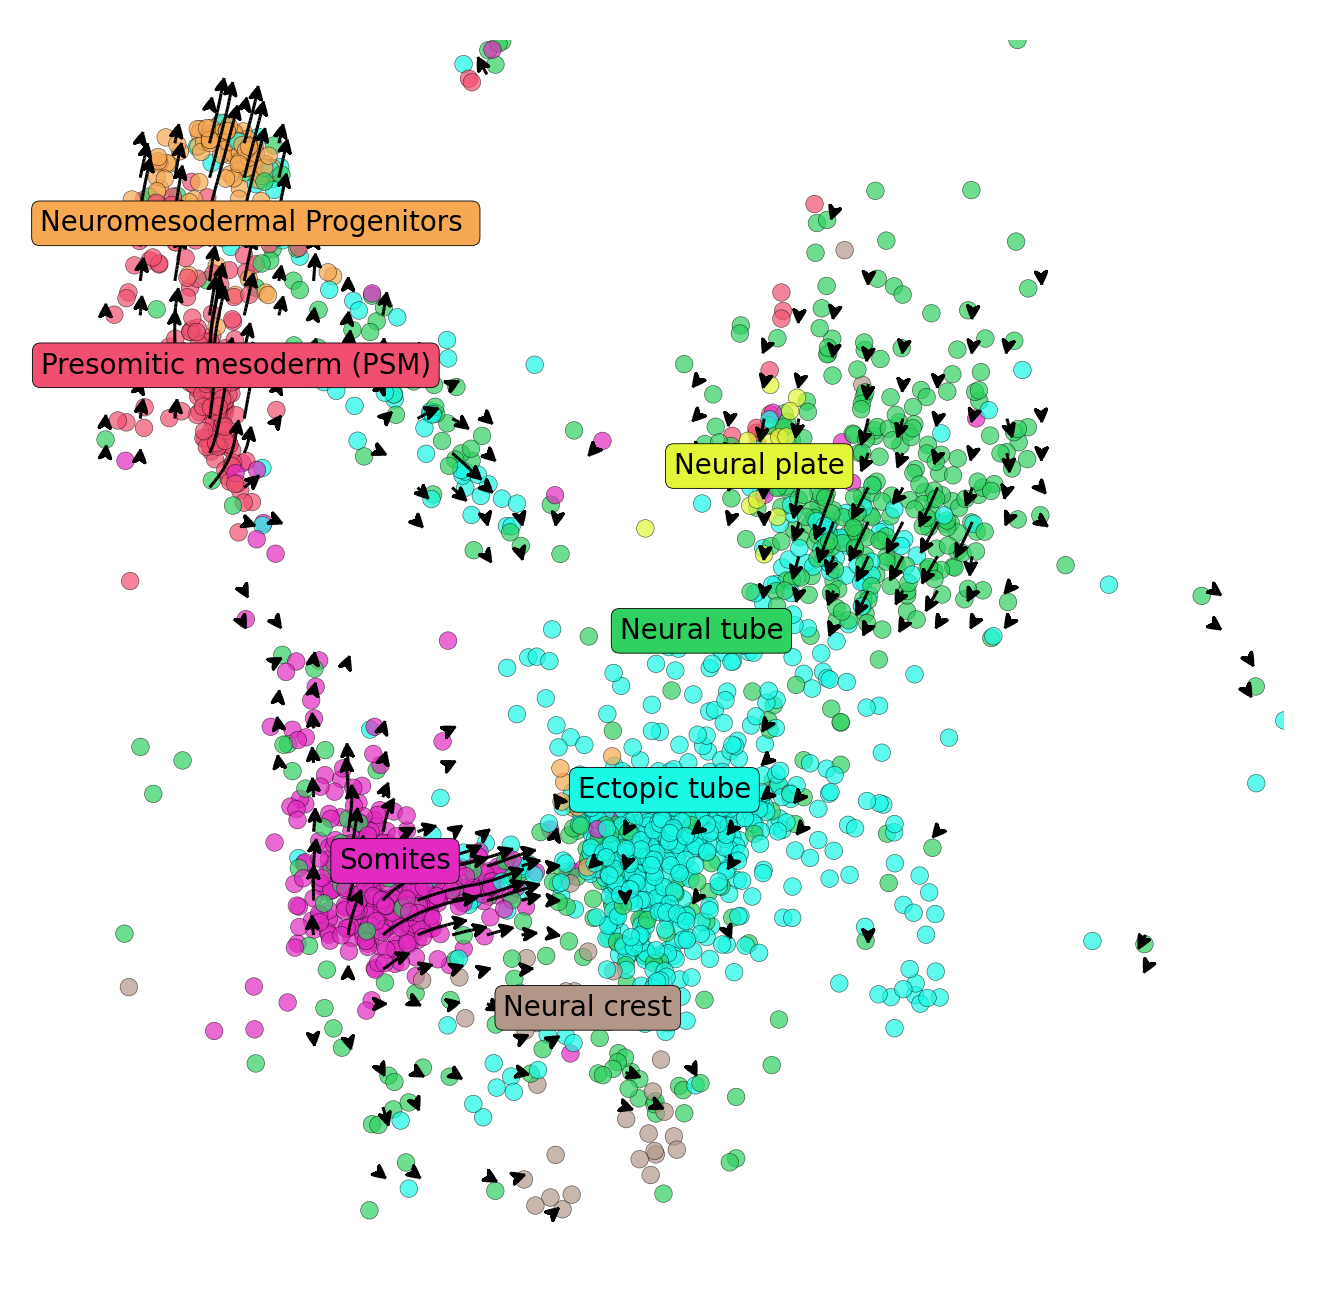

In [53]:
# perturbed_df = pd.read_parquet('/Users/koush/Downloads/Tbx6_4n_0x.parquet')

grid_points, vector_field = embryo.plot_arrows(
    perturb_target='', 
    perturbed_df=dfko,
    mode='0',
    hue='cell_type_2',
    curve=True,
    vector_scale=1, 
    grid_scale=1,
    n_neighbors=300,
    scale=10, 
    grains=35,
    figsize=(4, 4),
    dpi=200,
    alpha=0.7,
    scatter_size=10,
    legend_fontsize=5,
    # rename={},
    grey_out=False,
    limit_clusters=True,
    highlight_clusters=[
        # 'Ectopic tube',
        'Neural tube',
        'Somites',
        'Presomitic mesoderm (PSM)',
        'Neuromesodermal Progenitors ',
        'Neural crest',
    ]
)
# plt.savefig(
#     './figures/Tbx6_ko.svg', 
#     **savefig_params
# )
plt.show()

In [38]:
perturbed_df = pd.read_parquet('/Users/koush/Downloads/Sox2_4n_maxx.parquet')

grid_points, vector_field = embryo.plot_arrows(
    perturb_target='', 
    perturbed_df=perturbed_df,
    mode='0',
    hue='cell_type_2',
    curve=True,
    vector_scale=1, 
    grid_scale=1,
    n_neighbors=450,
    scale=10, 
    grains=35,
    figsize=(4, 4),
    dpi=200,
    alpha=0.7,
    scatter_size=10,
    legend_fontsize=5,
    # rename={},
    grey_out=False,
    limit_clusters=True,
    highlight_clusters=[
        # 'Ectopic tube',
        'Neural tube',
        'Somites',
        'Presomitic mesoderm (PSM)',
        'Neuromesodermal Progenitors ',
        'Neural crest',
    ]
)
# plt.savefig(
#     './figures/Tbx6_ko.svg', 
#     **savefig_params
# )
plt.show()

KeyError: "['200808_21_AAAGCCCAAGGTTG', '200808_21_TGTTTTTTTCTTCT', '200808_21_TTGTCAGAGGTCCG', '200808_21_CCCAAATTCTGCCT', '200808_21_CCAGGTAGCCCAAC', '200808_21_ATGATACTTACTAC', '200808_21_TGTAATCTTAGCGC', '200808_21_ATCGTTCACGCGGC', '200808_21_GCATTCGGTAGGTT', '200808_21_ATGACAGATCCTAC', '200808_21_CGTGAGGCACCTGG', '200808_21_AACGACTCTTGGAA', '200808_21_TTGTAATCTCCACC', '200808_21_GGAGCTCATCATTC', '200808_21_CAATACGGGCTTGG', '200808_21_GAATTAATCACTTG', '200808_21_GTGACCTACCGGCC', '200808_21_ATATCAGCCATTAC', '200808_21_CAAACTGAAACAAC', '200808_21_TTTTTAAGCCACCA', '200808_21_GTCAATCTTGCCGG', '200808_21_TGTCGCGTCTGCGC', '200808_21_CGTGTTTTAAGAGG', '200808_21_GATAGAACAAACGA', '200808_21_GGAGGTCAGGCTAA', '200808_21_CGGGGTGGTATAGT', '200808_21_GACACGGGCAATAA', '200808_21_ACACCGGGCTGAAT', '200808_21_CTACCAAGGCATCC', '200808_21_CTAAAAAGGATTGA', '200808_21_TAGCACCATTTGGA', '200808_21_CAGCTTGTTCATGA', '200808_21_TGACGGGGGAGCTG', '200808_21_CACCCCCTAGCTGT', '200808_21_AAAACCGACCTCAC', '200808_21_TTATGTATTTTTGG', '200808_21_CAGAGCTTGCGGCC', '200808_21_TGGTGAGGGAAGTA', '200808_21_TATCTGATTACGCC', '200808_21_TCCACAGTTACTCG', '200808_21_ACTAGCGCCCCGAA', '200808_21_GGGAAGAATGTCGA', '200808_21_TATCATTTAAGCGA', '200808_21_ATCTCGACGAGCTC', '200808_21_ACAGGAGCACAAGC', '200808_21_GACAATTTCTACGA', '200808_21_GACCGACATCTCTA', '200808_21_TACCGAAAGCCGAA', '200808_21_GCACAGAGTGCTGA', '200808_21_GATAGTGAATCTTC', '200808_21_GACAAACTACTGAG', '200808_21_CCGAGACTGGCCCT', '200808_21_GTGAAGTGGGGCAC', '200808_21_CAGGGCCGCATGTG', '200808_21_GGGAAGGGACGTAC', '200808_21_GCTGCCTCGTCCGT', '200808_21_GAACGGGCCTCGCC', '200808_21_ACAAACCTACGATG', '200808_21_ATGGAAGGTATCTA', '200808_21_CCGCCCGGATCGCC', '200808_21_CGGATAGATCCCAC', '200808_21_TCGGGATCCCACTA', '200808_21_TACCAGGCTTCACG', '200808_21_CTCTACTTTTCGCA', '200808_21_CTGCGTTCACAGAT', '200808_21_TAGCAAGCCCTCTT', '200808_21_CGGGGCAGCTTAGC', '200808_21_GCAGCATATAACGT', '200808_21_AAACTAACTGACAT', '200808_21_GGCAGAACGTCATT', '200808_21_GCACCGGCTATGGG', '200808_21_TACATCCTTCCGAC', '200808_21_TAATCTTACGAGGT', '200808_21_GAGGCTTACAACCT', '200808_21_CTCGGCTCGACGAA', '200808_21_AGGAGATTACAAGT', '200808_21_GTGAAGTTTCATAA', '200808_21_TGTTCAATTCCCGG', '200808_21_ATAGAGAAATTTCA', '200808_21_CTATATTCCTTAAC', '200808_21_TCTGAACTTGAGCT', '200808_21_ATTCAGAAAGTTGT', '200808_21_GCCGATAAGACAGC', '200808_21_GCCCCGGATTAATA', '200808_21_CCAGGTCACATGCA', '200808_21_GTCGGAGGGCGACG', '200808_21_CCAAGCGCTCGAAG', '200808_21_AGTCATATGGTAAA', '200808_21_GCTTCAAGGTAGTC', '200808_21_GTCTAAGTTTGGAT', '200808_21_ACCCCAGATAAGCA', '200808_21_AGGAGTTAACGATC', '200808_21_GTGGTAAGGAACGA', '200808_21_ACTTGAACATAAAA', '200808_21_TCTTTCTTGGCTCA', '200808_21_TCGGTGTACATTCA', '200808_21_TACGTCCCTACGCT', '200808_21_TCCAAAACTAGATC', '200808_21_TATACCCCCGTCGG', '200808_21_TGTTAAACACAGCG', '200808_21_TTTTTGAGATGGCT', '200808_21_CCAGGAGCCTGCGG', '200808_21_GGGCTACTCCCTAT', '200808_21_ACCTCTAAGGCCAA', '200808_21_TCCACTCTCATAGT', '200808_21_ATGGATGTGTAGAC', '200808_21_TTTCTCCGGTAACA', '200808_21_TAGTTAATTACCGT', '200808_21_AAAGTGTTCCCTCC', '200808_21_GCACCCAAGTGGGC', '200808_21_CTGTTTCAATATTT', '200808_21_CAGTGAAGCTAAGG', '200808_21_ATACCGCACGAGAG', '200808_21_AGTCTGGTAGTGGA', '200808_21_TCATCACGCGGTAT', '200808_21_CGAATCCAATAGGG', '200808_21_ACACAATATGCCTA', '200808_21_ACATAAAAGCCTCT', '200808_21_TTCGTAACTGTCTC', '200808_21_CTTTCGCTTTAATG', '200808_21_ATTGCCCCGATTAC', '200808_21_TAACTAACGTCCAT', '200808_21_GAGGCCCGTGCCAA', '200808_21_CCGTGGGGGAATGC', '200808_21_TCGCTAAAAACGAA', '200808_21_TAATATCATGGTCA', '200808_21_GACCGGAGCTTTCA', '200808_21_AATTAGCCGAATGT', '200808_21_GGAGTGTGGCTCAT', '200808_21_ATGCAAATAGACAT', '200808_21_ATCGTAAAGTACCC', '200808_21_TGCGGTTTATAACG', '200808_21_CTACCAATTGCATA', '200808_21_GCCCTTTCGCGAAT', '200808_21_ATACTTTCCGCGGT'] not in index"